# 주차 수요 예측

## 라이브러리 불러오기

In [2]:
!pip install koreanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 24.0 MB/s eta 0:00:00


In [3]:
from glob import glob 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import plotly.express as px 
import folium

## 컬럼 설명

train data column description :
- 단지코드(key)
- 총세대수
- 임대건물구분
- 지역
- 공급유형
- 전용면적
- 전용면적별세대수
- 공가수: 빈집
- 자격유형: 임차를 할 수 있는 자격 요건
- 임대료보증금
- 임대료
- 도보 10분거리 내 지하철역 수(환승노선 수 반영)
- 도보 10분거리 내 버스정류장 수
- 단지내주차면수
- 등록차량수(target)

## 데이터 불러오기

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/drive/MyDrive/Colab Notebooks/미드 프로젝트 2/235745_parking_data.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/미드 프로젝트 2/235745_parking_data.zip
  inflating: age_gender_info.csv     
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [125]:
base_path = "."
# train 변수에 train.csv 데이터를 불러옵니다.
# test 변수에 test.csv 데이터를 불러옵니다.
# submission 변수에 sample_submission.csv 데이터를 불러옵니다.
train = pd.read_csv(f'{base_path}/train.csv')
test = pd.read_csv(f'{base_path}/test.csv')
age_gender = pd.read_csv(f'{base_path}/age_gender_info.csv')


In [126]:
train.shape, test.shape,age_gender.shape

((2952, 15), (1022, 14), (16, 23))

## 데이터 타입 

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          1022 non-null   object 
 1   총세대수                          1022 non-null   int64  
 2   임대건물구분                        1022 non-null   object 
 3   지역                            1022 non-null   object 
 4   공급유형                          1022 non-null   object 
 5   전용면적                          1022 non-null   float64
 6   전용면적별세대수                      1022 non-null   int64  
 7   공가수                           1022 non-null   float64
 8   자격유형                          1020 non-null   object 
 9   임대보증금                         842 non-null    object 
 10  임대료                           842 non-null    object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  980 non-null    float64
 12  도보 10분거리 내 버스정류장 수            1022 non-null   float64
 13  단지내

In [10]:
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0
2948,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2949,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2950,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000,142310,0.0,1.0,166.0,146.0


# 오류 1번 : 전용면적별 세대수 합계와 총세대수가 일치하지 않는 경우  

![image.png](attachment:image.png)

In [127]:
train=train.drop_duplicates()
test=test.drop_duplicates()

In [128]:
differ = train.groupby('단지코드').agg({'총세대수':'unique', '전용면적별세대수':'sum'})
differ['총세대수'] = differ['총세대수'].str[0].astype(int)
differ = differ[differ['총세대수'] != differ['전용면적별세대수']]
differ['차이'] = differ['총세대수'] - differ['전용면적별세대수']
differ

,총세대수,전용면적별세대수,차이
단지코드,,,
C1004,521,517,4
C1024,680,477,203
C1056,410,401,9
C1068,806,805,1
C1109,1957,1952,5
...,...,...,...
C2583,1106,1034,72
C2597,1005,991,14
C2620,1029,906,123


Text(0.5, 1.0, '총세대수와 전용면적별 세대수 합계 차')

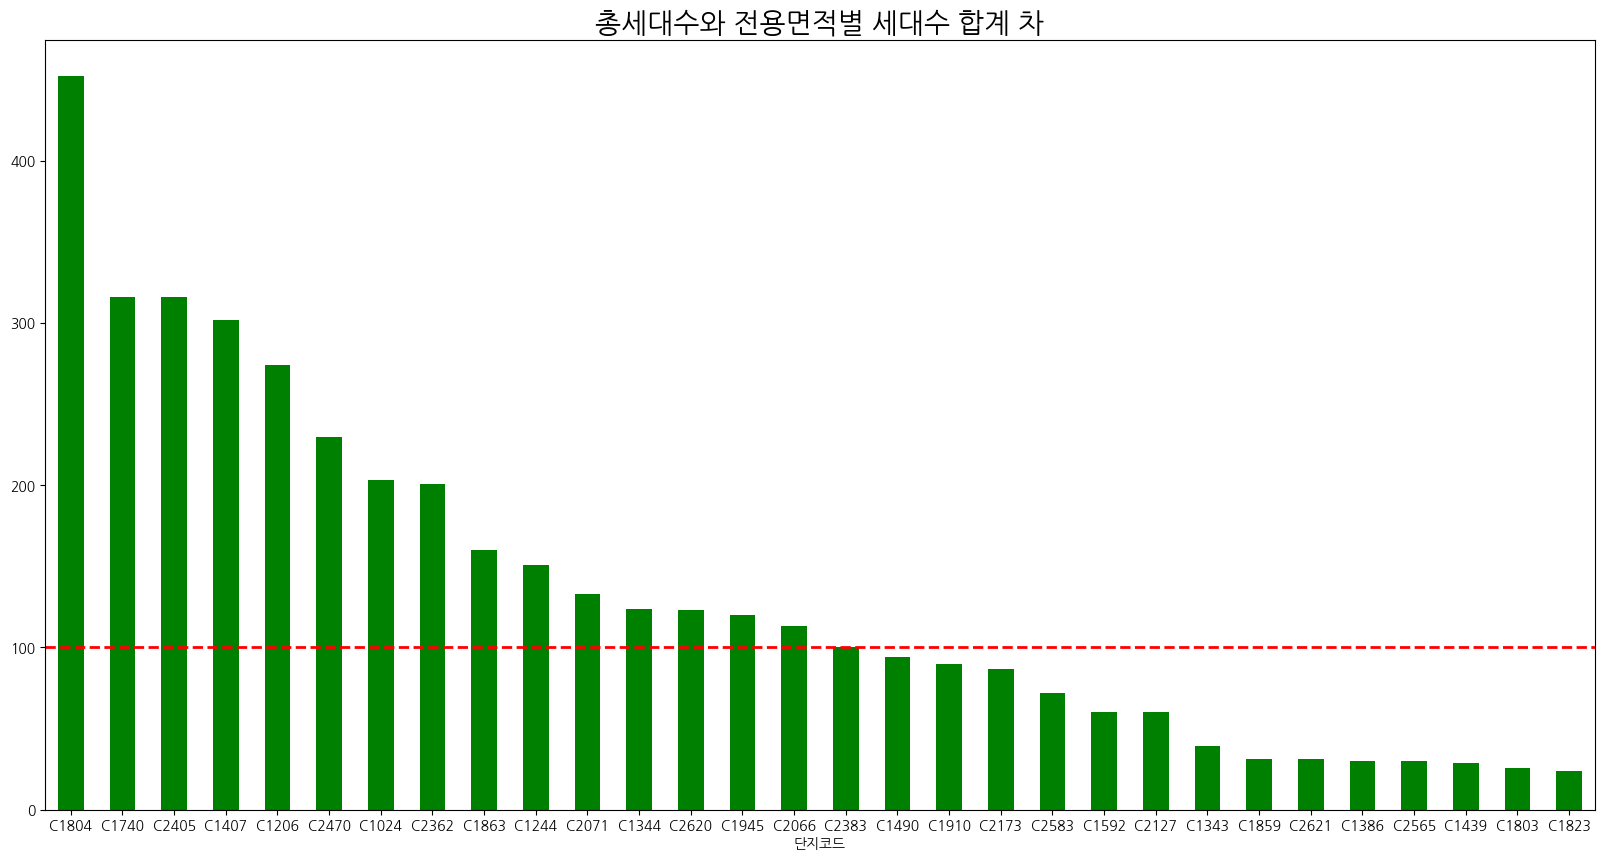

In [129]:
ax = differ.loc[differ['차이'] > 20, '차이'].sort_values(ascending=False).plot.bar(figsize=(20,10), color='Green', rot=0)
ax.axhline(y=100, color='r', linestyle='--', linewidth=2)
ax.set_title('총세대수와 전용면적별 세대수 합계 차', fontsize=20)


## 총세대수를 드랍하고 전용면적별세대수의 합계로 대체 

In [130]:
correct_train = train.groupby('단지코드').agg({'전용면적별세대수':'sum'})
train['총합계'] = train['단지코드'].map(correct_train['전용면적별세대수'])

In [131]:
correct_test = test.groupby('단지코드').agg({'전용면적별세대수':'sum'})
test['총합계'] = test['단지코드'].map(correct_test['전용면적별세대수'])

In [132]:
# 기존 세대수 column 삭제 and 컬럼 순서 조정 
train = train[['단지코드', '총합계', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수']]

In [134]:
# 기존 세대수 column 삭제 and 컬럼 순서 조정 
test = test[['단지코드', '총합계', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수']]

# 오류 2번 : 동일한 단지에 단지코드가 2개로 부여된 경우  



![image.png](attachment:image.png)

In [135]:
# 오류 2번 해당 train 데이터셋 제거
train = train[train['단지코드'] != 'C2085']
train = train[train['단지코드'] != 'C1397']
train = train[train['단지코드'] != 'C2431']
train = train[train['단지코드'] != 'C1649']
train = train[train['단지코드'] != 'C1036']

# 오류 3번 : 단지코드 등 기입 실수로 데이터 정제 과정에서 매칭 오류 발생  



![%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202023-04-04%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.44.35.png](attachment:%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202023-04-04%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.44.35.png)

In [136]:
# 오류 3번 해당 train 데이터셋 제거
train = train[train['단지코드'] != 'C1095']
train = train[train['단지코드'] != 'C2051']
train = train[train['단지코드'] != 'C1218']
train = train[train['단지코드'] != 'C1894']
train = train[train['단지코드'] != 'C2483']
train = train[train['단지코드'] != 'C1502']
train = train[train['단지코드'] != 'C1988']

* 오류값 조정 후 shape 값 비교
![image.png](attachment:image.png)

In [137]:
train.shape, test.shape

((2549, 15), (949, 14))

In [138]:
train.copy()

,단지코드,총합계,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0
9,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000,107130,0.0,3.0,624.0,205.0
10,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000,107130,0.0,3.0,624.0,205.0
11,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000,149760,0.0,3.0,624.0,205.0
12,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000,149760,0.0,3.0,624.0,205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0
2948,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2949,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2950,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000,142310,0.0,1.0,166.0,146.0


# 결측치 확인

In [139]:
train.isnull().sum()

단지코드                              0
총합계                               0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           292
임대료                             292
도보 10분거리 내 지하철역 수(환승노선 수 반영)    151
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [140]:
## 결측치 확인

train.isnull().sum()

단지코드                              0
총합계                               0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           292
임대료                             292
도보 10분거리 내 지하철역 수(환승노선 수 반영)    151
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [24]:
train.isnull().sum() #-> 각 column별로 null값의 개수 더해서 알려줌
train.isnull().sum().sum() #-> 전체 데이터프레임의 null값의 개수 

735

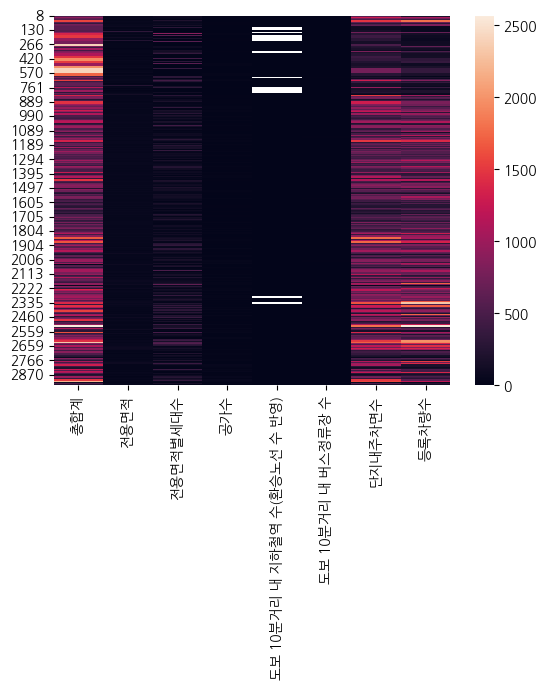

In [25]:
sns.heatmap(train.select_dtypes(include="number"));

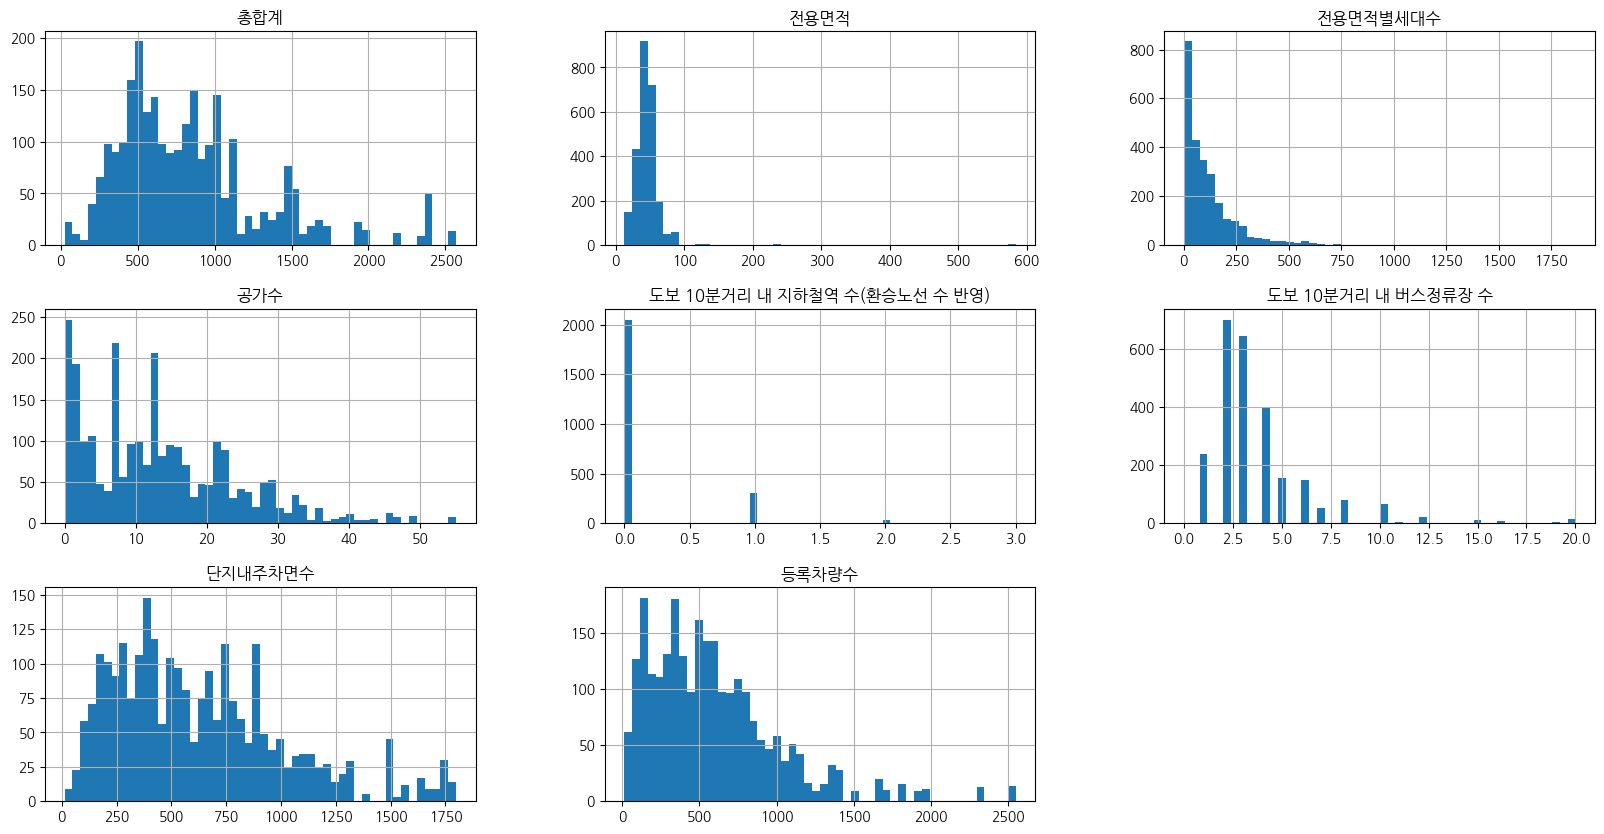

In [141]:
train.hist(bins=50,figsize=(20, 10))
plt.show();

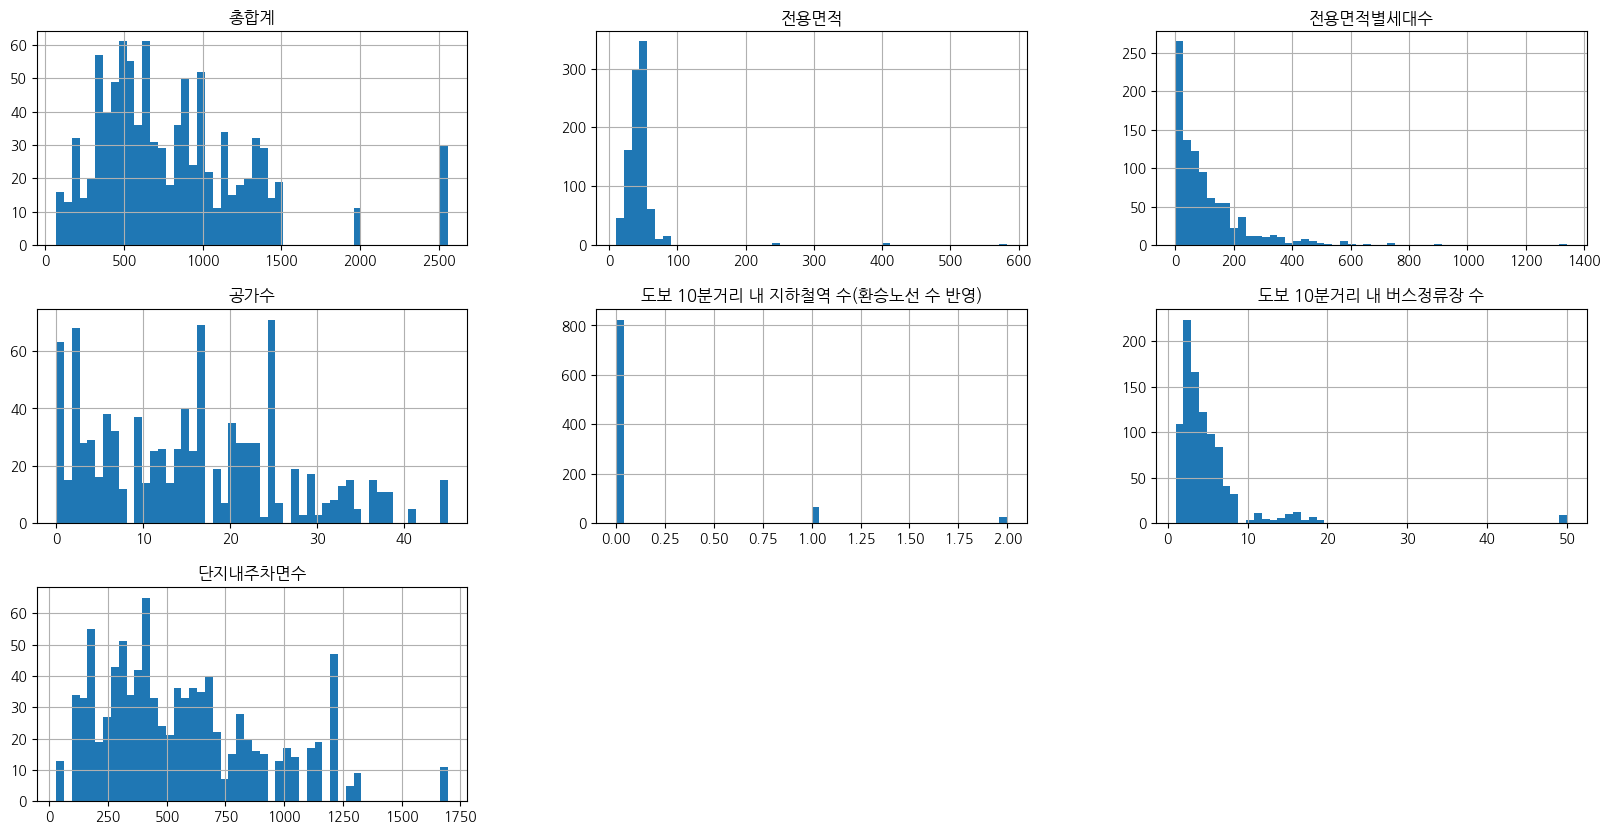

In [142]:
test.hist(bins=50,figsize=(20, 10))
plt.show();

<Axes: >

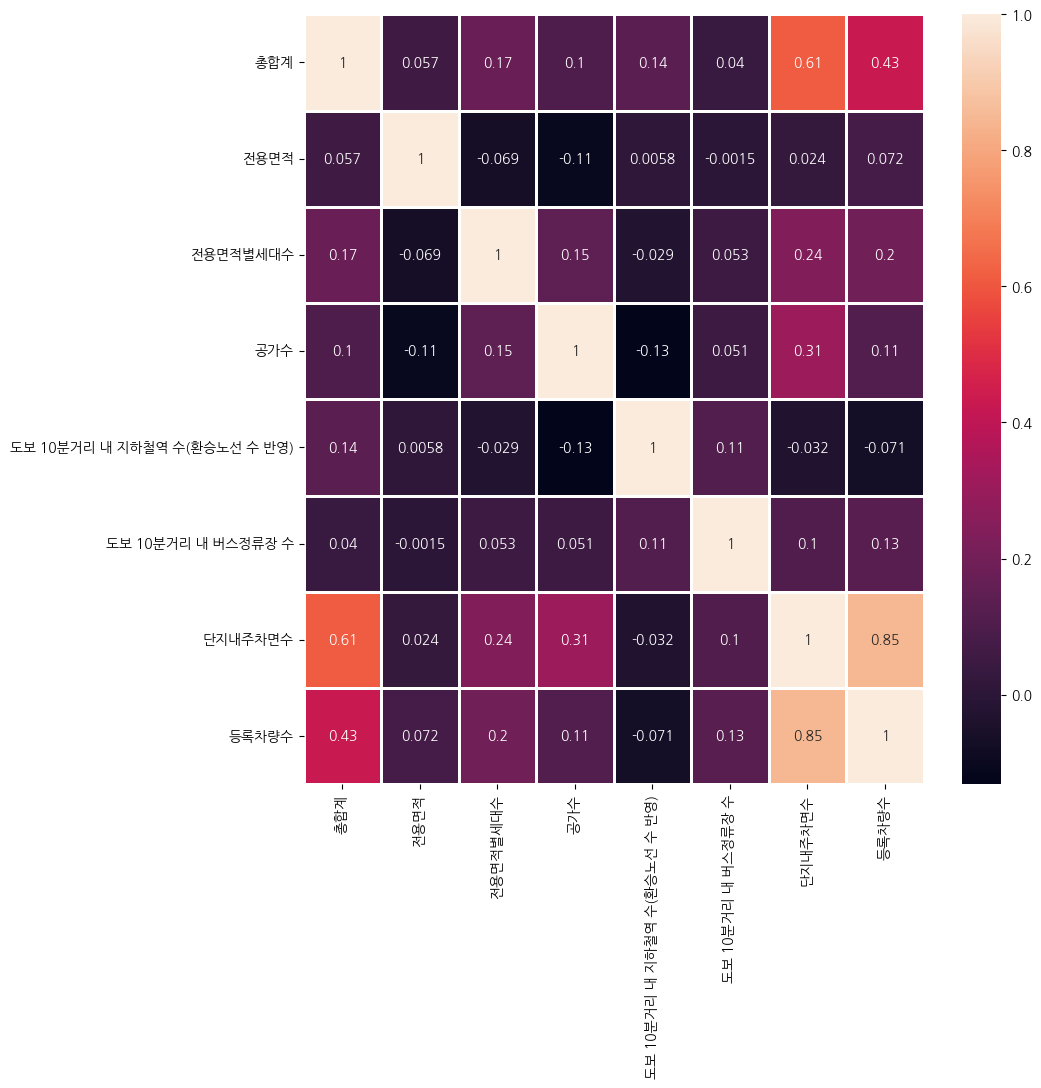

In [143]:
# 상관계수
corr_matrix = train.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, linewidth=1)
#단지 내에 주차 차량수랑 등록 차량수가 가장 많은걸 알 수 있음

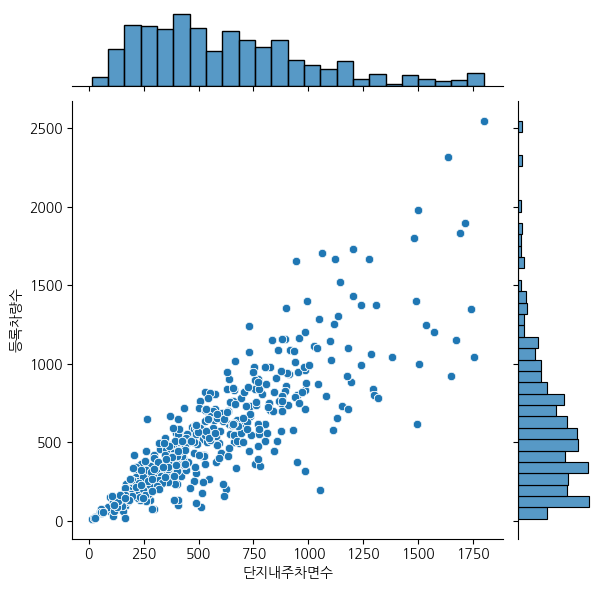

In [144]:
sns.jointplot(x="단지내주차면수", y="등록차량수", data=train, kind='scatter')

In [145]:
pd.crosstab(train['공급유형'],train['자격유형'] ,margins=True).style.background_gradient(cmap='summer_r')

자격유형,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,All
공급유형,,,,,,,,,,,,,,,,
공공분양,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,7
공공임대(10년),173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,173
공공임대(50년),31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31
공공임대(5년),3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
공공임대(분납),7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
국민임대,1484,18,0,0,34,0,9,154,0,0,0,0,0,0,0,1699
영구임대,2,0,92,0,3,3,0,0,49,0,0,0,0,0,0,149
임대상가,0,0,0,285,0,0,0,0,0,0,0,0,0,0,0,285
장기전세,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


# 임대 보증금 과 임대료 전처리

In [146]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan

In [147]:
# 임대 보증금 타입 변경 
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)


In [148]:
train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan

In [149]:
# 임대 보증금 타입 변경
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

In [150]:
#임대료 처리 
train.loc[train['공급유형'] == '공공분양', '임대료'] = train['임대료'].fillna(0)
train.loc[train['공급유형'] == '장기전세', '임대료'] = train['임대료'].fillna(0)
train.loc[train['공급유형'] == '국민임대', '임대료'] = train['임대료'].fillna(0)
train.loc[train['공급유형'] == '행복주택', '임대료'] = train['임대료'].fillna(0)


In [151]:
#임대보증금 처리
train.loc[train['공급유형'] == '공공분양', '임대보증금'] = train['임대보증금'].fillna(0)
train.loc[train['공급유형'] == '장기전세', '임대보증금'] = train['임대보증금'].fillna(0)
train.loc[train['공급유형'] == '국민임대', '임대보증금'] = train['임대보증금'].fillna(0)
train.loc[train['공급유형'] == '행복주택', '임대보증금'] = train['임대보증금'].fillna(0)


In [152]:
train.loc[train['지역'] == '부산광역시', '임대료'] = train['임대료'].fillna(train[train['지역'] == '부산광역시']['임대료'].mean())
train.loc[train['지역'] == '대전광역시', '임대료'] = train['임대료'].fillna(train[train['지역'] == '대전광역시']['임대료'].mean())
train.loc[train['지역'] == '경상남도', '임대료'] = train['임대료'].fillna(train[train['지역'] == '경상남도']['임대료'].mean())
train.loc[train['지역'] == '충청남도', '임대료'] = train['임대료'].fillna(train[train['지역'] == '충청남도']['임대료'].mean())
train.loc[train['지역'] == '강원도', '임대료'] = train['임대료'].fillna(train[train['지역'] == '강원도']['임대료'].mean())
train.loc[train['지역'] == '제주특별자치도', '임대료'] = train['임대료'].fillna(train[train['지역'] == '제주특별자치도']['임대료'].mean())

In [153]:
#임대 상가의 임대보증금 처리 
train.loc[train['지역'] == '부산광역시', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '부산광역시']['임대보증금'].mean())
train.loc[train['지역'] == '대전광역시', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '대전광역시']['임대보증금'].mean())
train.loc[train['지역'] == '경상남도', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '경상남도']['임대보증금'].mean())
train.loc[train['지역'] == '충청남도', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '충청남도']['임대보증금'].mean())
train.loc[train['지역'] == '강원도', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '강원도']['임대보증금'].mean())
train.loc[train['지역'] == '제주특별자치도', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '제주특별자치도']['임대보증금'].mean())

In [154]:
train.groupby(['공급유형'], as_index=False)['임대료'].mean()

,공급유형,임대료
0,공공분양,0.000000
1,공공임대(10년),516312.601156
2,공공임대(50년),201579.677419
3,공공임대(5년),400000.000000
4,공공임대(분납),263968.571429
5,국민임대,171642.224838
6,영구임대,93657.516779
7,임대상가,168658.765733
8,장기전세,0.000000
9,행복주택,122576.406250


In [40]:
#임대료 처리 
test.loc[test['공급유형'] == '영구임대', '임대료'] = test['임대료'].fillna(0)
test.loc[test['공급유형'] == '행복주택', '임대료'] = test['임대료'].fillna(0)

In [41]:
#임대보증금 처리
test.loc[test['공급유형'] == '영구임대', '임대보증금'] = test['임대보증금'].fillna(0)
test.loc[test['공급유형'] == '행복주택', '임대보증금'] = test['임대보증금'].fillna(0)

In [42]:
#임대 상가의 임대료 처리  (test 특성 기준 test null 값 처리는 data leakage 여서 train의 지역 기준으로 test 처리)
test.loc[test['지역'] == '부산광역시', '임대료'] = test['임대료'].fillna(train[train['지역'] == '부산광역시']['임대료'].mean())
test.loc[test['지역'] == '대전광역시', '임대료'] = test['임대료'].fillna(train[train['지역'] == '대전광역시']['임대료'].mean())
test.loc[test['지역'] == '울산광역시', '임대료'] = test['임대료'].fillna(train[train['지역'] == '울산광역시']['임대료'].mean())
test.loc[test['지역'] == '충청남도', '임대료'] = test['임대료'].fillna(train[train['지역'] == '충청남도']['임대료'].mean())
test.loc[test['지역'] == '강원도', '임대료'] = test['임대료'].fillna(train[train['지역'] == '강원도']['임대료'].mean())  


In [43]:
#임대 상가의 임대보증금 처리 
test.loc[test['지역'] == '부산광역시', '임대보증금'] = test['임대보증금'].fillna(train[train['지역'] == '부산광역시']['임대보증금'].mean())
test.loc[test['지역'] == '대전광역시', '임대보증금'] = test['임대보증금'].fillna(train[train['지역'] == '대전광역시']['임대보증금'].mean())
test.loc[test['지역'] == '울산광역시', '임대보증금'] = test['임대보증금'].fillna(train[train['지역'] == '울산광역시']['임대보증금'].mean())
test.loc[test['지역'] == '충청남도', '임대보증금'] = test['임대보증금'].fillna(train[train['지역'] == '충청남도']['임대보증금'].mean())
test.loc[test['지역'] == '강원도', '임대보증금'] = test['임대보증금'].fillna(train[train['지역'] == '강원도']['임대보증금'].mean())

# 버스 정류장 및 지하철 수 처리

In [155]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0).copy()
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0).copy()
train['도보 10분거리 내 버스정류장 수'] = train['도보 10분거리 내 버스정류장 수'].fillna(0).copy()

In [156]:
test[test['도보 10분거리 내 버스정류장 수']==50]   ##상식적으로 있을 수 없는 값이라고 판단 

,단지코드,총합계,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
383,C1852,898,아파트,경기도,국민임대,39.59,219,6.0,H,23720000.0,197230.0,0.0,50.0,785.0
384,C1852,898,아파트,경기도,국민임대,39.72,56,6.0,A,23720000.0,197230.0,0.0,50.0,785.0
385,C1852,898,아파트,경기도,국민임대,39.72,44,6.0,A,23720000.0,197230.0,0.0,50.0,785.0
386,C1852,898,아파트,경기도,국민임대,46.90,46,6.0,A,37454000.0,259660.0,0.0,50.0,785.0
387,C1852,898,아파트,경기도,국민임대,46.90,22,6.0,A,37454000.0,259660.0,0.0,50.0,785.0
388,C1852,898,아파트,경기도,국민임대,46.90,225,6.0,H,37454000.0,259660.0,0.0,50.0,785.0
389,C1852,898,아파트,경기도,국민임대,51.93,136,6.0,H,45193000.0,308350.0,0.0,50.0,785.0
390,C1852,898,아파트,경기도,국민임대,51.93,44,6.0,H,45193000.0,308350.0,0.0,50.0,785.0
391,C1852,898,아파트,경기도,국민임대,59.61,106,6.0,H,61674000.0,370790.0,0.0,50.0,785.0


In [157]:
##train의 평균 값으로 처리 
test.loc[test['도보 10분거리 내 버스정류장 수'] == 50,'도보 10분거리 내 버스정류장 수'] = train['도보 10분거리 내 버스정류장 수'].mean()
test

,단지코드,총합계,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000.0,189840.0,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000.0,249930.0,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000.0,249930.0,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000.0,249930.0,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000.0,296780.0,0.0,2.0,683.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,C1267,670,아파트,경상남도,행복주택,36.77,126,38.0,L,NaN,NaN,0.0,1.0,467.0
1018,C2189,378,아파트,전라북도,국민임대,29.19,96,45.0,H,6872000.0,106400.0,0.0,2.0,300.0
1019,C2189,378,아파트,전라북도,국민임대,29.19,20,45.0,H,6872000.0,106400.0,0.0,2.0,300.0
1020,C2189,378,아파트,전라북도,국민임대,39.45,202,45.0,H,13410000.0,144600.0,0.0,2.0,300.0


# 자격유형 처리

In [158]:
test[test.자격유형.isnull()]

,단지코드,총합계,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,961,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
258,C2253,1149,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000.0,44770.0,0.0,2.0,173.0


In [159]:
test[test.단지코드=='C2411']

,단지코드,총합계,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
193,C2411,961,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
194,C2411,961,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
195,C2411,961,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
196,C2411,961,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
197,C2411,961,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000.0,171480.0,0.0,2.0,840.0


In [160]:
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test[test.단지코드=='C2411']

,단지코드,총합계,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
193,C2411,961,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
194,C2411,961,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
195,C2411,961,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
196,C2411,961,아파트,경상남도,국민임대,46.90,240,25.0,A,71950000.0,37470.0,0.0,2.0,840.0
197,C2411,961,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000.0,171480.0,0.0,2.0,840.0


In [161]:
test[test.단지코드=='C2253']

,단지코드,총합계,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
258,C2253,1149,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000.0,44770.0,0.0,2.0,173.0
259,C2253,1149,아파트,강원도,영구임대,31.32,239,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
260,C2253,1149,아파트,강원도,영구임대,31.32,149,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
261,C2253,1149,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0.0,2.0,173.0
262,C2253,1149,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0.0,2.0,173.0
263,C2253,1149,상가,강원도,임대상가,22.91,1,0.0,D,NaN,NaN,0.0,2.0,173.0
264,C2253,1149,상가,강원도,임대상가,23.79,1,0.0,D,NaN,NaN,0.0,2.0,173.0
266,C2253,1149,상가,강원도,임대상가,23.86,1,0.0,D,NaN,NaN,0.0,2.0,173.0
268,C2253,1149,상가,강원도,임대상가,24.19,1,0.0,D,NaN,NaN,0.0,2.0,173.0
269,C2253,1149,상가,강원도,임대상가,27.75,1,0.0,D,NaN,NaN,0.0,2.0,173.0


In [162]:
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'
test[test.단지코드=='C2253']

,단지코드,총합계,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
258,C2253,1149,아파트,강원도,영구임대,26.37,745,0.0,C,2249000.0,44770.0,0.0,2.0,173.0
259,C2253,1149,아파트,강원도,영구임대,31.32,239,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
260,C2253,1149,아파트,강원도,영구임대,31.32,149,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
261,C2253,1149,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0.0,2.0,173.0
262,C2253,1149,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0.0,2.0,173.0
263,C2253,1149,상가,강원도,임대상가,22.91,1,0.0,D,NaN,NaN,0.0,2.0,173.0
264,C2253,1149,상가,강원도,임대상가,23.79,1,0.0,D,NaN,NaN,0.0,2.0,173.0
266,C2253,1149,상가,강원도,임대상가,23.86,1,0.0,D,NaN,NaN,0.0,2.0,173.0
268,C2253,1149,상가,강원도,임대상가,24.19,1,0.0,D,NaN,NaN,0.0,2.0,173.0
269,C2253,1149,상가,강원도,임대상가,27.75,1,0.0,D,NaN,NaN,0.0,2.0,173.0


In [163]:
test.isnull().sum() #-> 각 column별로 null값의 개수 더해서 알려줌
test.isnull().sum().sum() #-> 전체 데이터프레임의 null값의 개수 

240

# age_gender 확인

In [164]:
# age_gender 확인
age_gender

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,...,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,...,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
5,강원도,0.028888,0.030682,0.051287,0.052712,0.060374,0.063157,0.059821,0.054321,0.076201,...,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
6,광주광역시,0.031994,0.034566,0.049851,0.050254,0.065084,0.066875,0.066888,0.064416,0.080028,...,0.075930,0.059586,0.048552,0.031754,0.029749,0.010341,0.006343,0.000895,0.000353,0.000013
7,충청남도,0.031369,0.031711,0.059077,0.062422,0.067975,0.072622,0.065095,0.067303,0.078860,...,0.070278,0.057692,0.042296,0.028682,0.024514,0.010900,0.005429,0.001549,0.000219,0.000123
8,부산광역시,0.022003,0.022947,0.032681,0.035512,0.053796,0.057233,0.047049,0.048866,0.061952,...,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028
9,제주특별자치도,0.034690,0.036695,0.060094,0.063080,0.069135,0.069667,0.050808,0.048026,0.080548,...,0.074248,0.055717,0.047944,0.033054,0.026836,0.011332,0.006832,0.000982,0.000368,0.000082


In [165]:
age_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지역         16 non-null     object 
 1   10대미만(여자)  16 non-null     float64
 2   10대미만(남자)  16 non-null     float64
 3   10대(여자)    16 non-null     float64
 4   10대(남자)    16 non-null     float64
 5   20대(여자)    16 non-null     float64
 6   20대(남자)    16 non-null     float64
 7   30대(여자)    16 non-null     float64
 8   30대(남자)    16 non-null     float64
 9   40대(여자)    16 non-null     float64
 10  40대(남자)    16 non-null     float64
 11  50대(여자)    16 non-null     float64
 12  50대(남자)    16 non-null     float64
 13  60대(여자)    16 non-null     float64
 14  60대(남자)    16 non-null     float64
 15  70대(여자)    16 non-null     float64
 16  70대(남자)    16 non-null     float64
 17  80대(여자)    16 non-null     float64
 18  80대(남자)    16 non-null     float64
 19  90대(여자)    16 non-null     float64
 20  90대(남자)    1

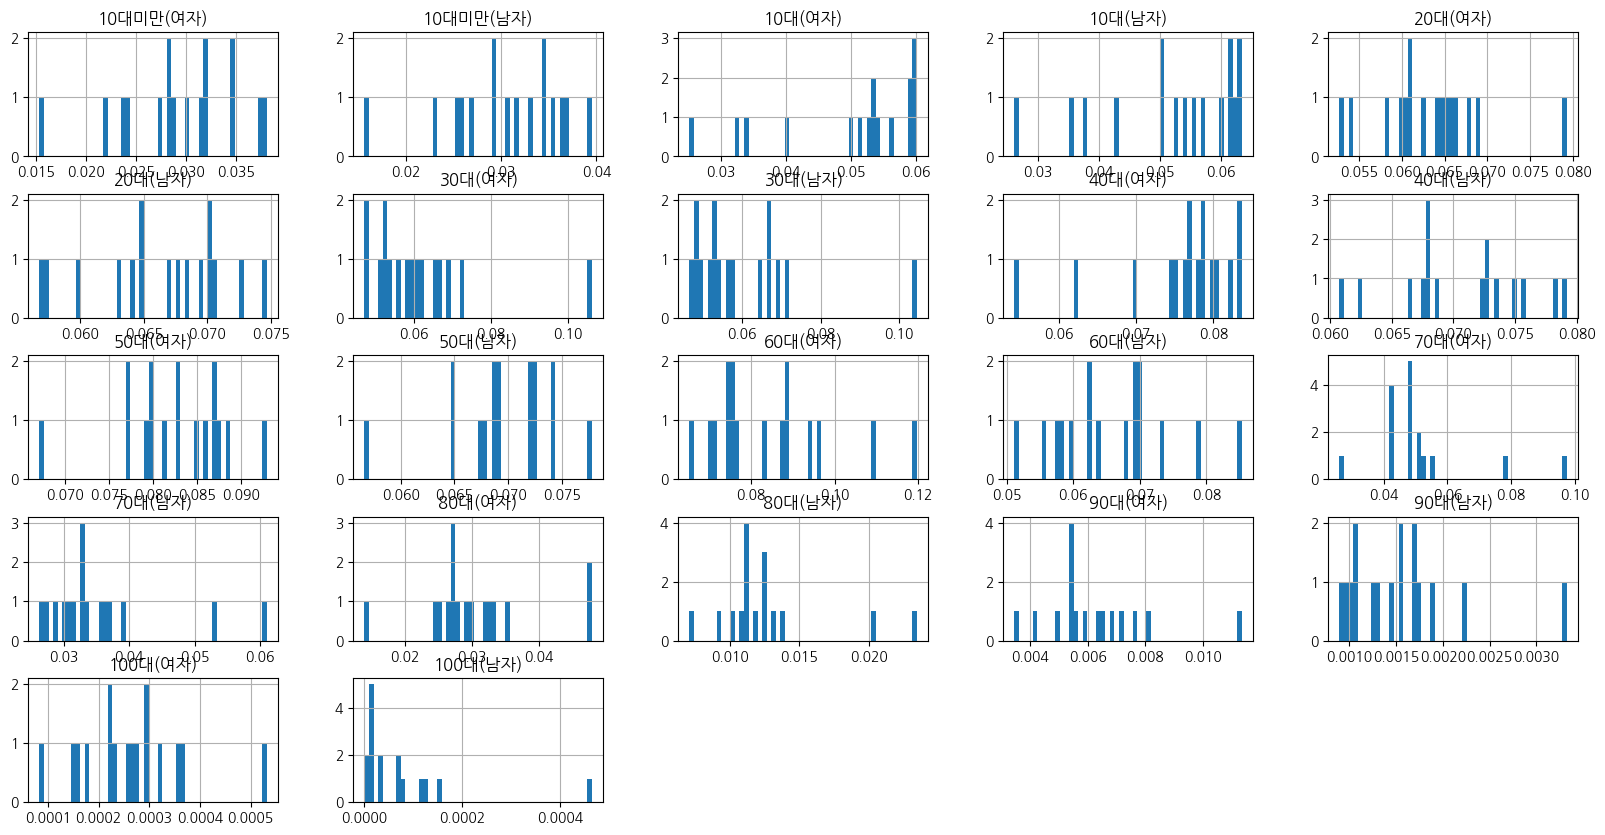

In [166]:
age_gender.hist(bins=50,figsize=(20, 10))
plt.show();

# age_gender에서 미성년자(20대 미만) , 80~100대 비율만 가져와서 합치기
 
- 운전을 안하는 나이대를 묶어 '운전 안하는 사람' 변수를 하나 만들었습니다.

In [167]:
minors = ['10대미만(여자)', '10대미만(남자)', '10대(여자)', '10대(남자)','80대(여자)','80대(남자)','90대(여자)','90대(남자)','100대(여자)','100대(남자)']
age_gender['운전 안하는 사람'] = age_gender[minors].sum(axis=1)

In [168]:
train = train.merge(age_gender, left_on= ["지역"], right_on= ["지역"], how='left')
test = test.merge(age_gender, left_on= ["지역"], right_on= ["지역"], how='left')

In [169]:
train

,단지코드,총합계,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),운전 안하는 사람
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,...,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010,0.207968
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000.0,...,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010,0.207968
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000.0,...,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010,0.207968
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000.0,...,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010,0.207968
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000.0,...,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010,0.207968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2544,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000.0,...,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017,0.219750
2545,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000.0,...,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017,0.219750
2546,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000.0,...,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017,0.219750
2547,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000.0,...,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017,0.219750



# 서울시 데이터가 전부 수집되어 있지 않은것으로 보여 서울시 데이터 삭제합니다.




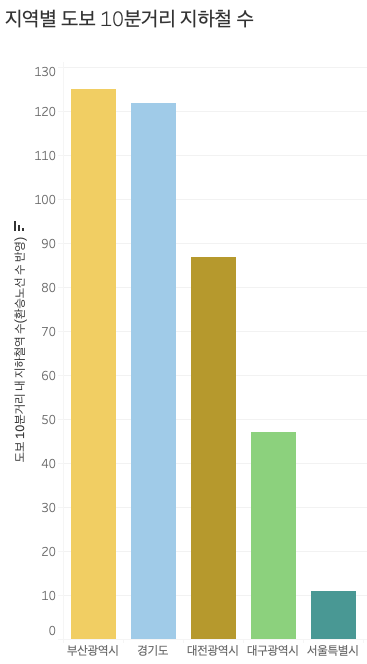

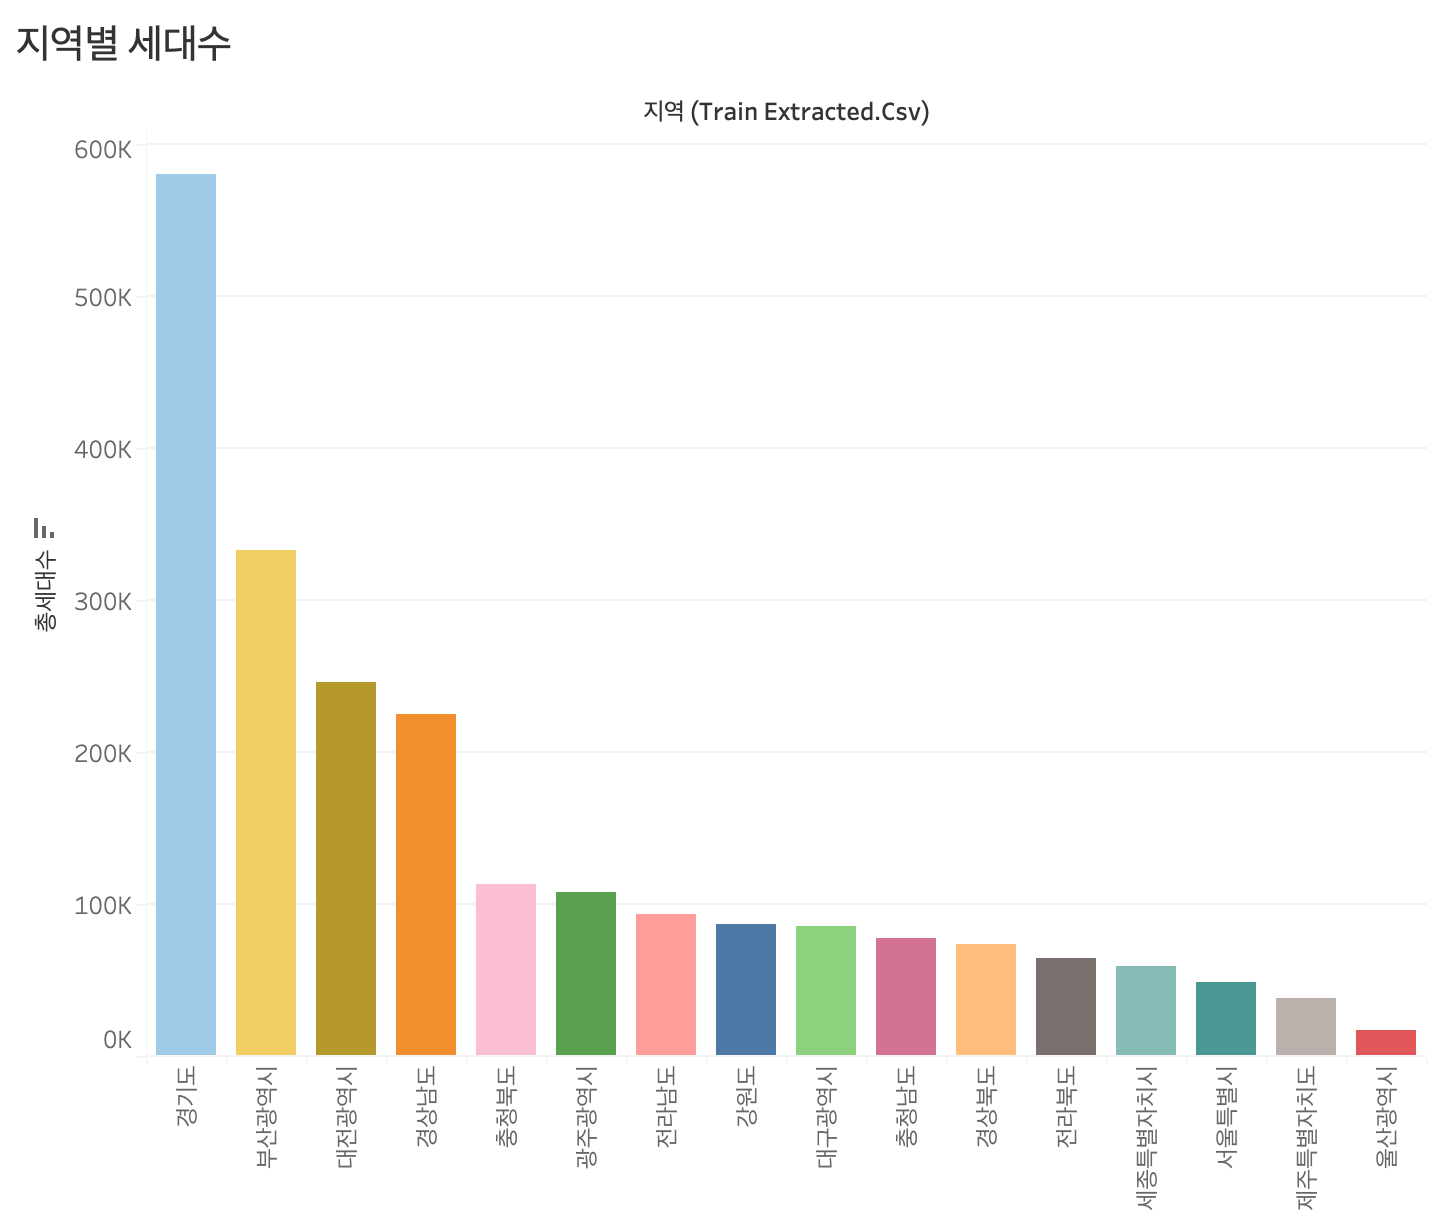

In [170]:
# 서울특별시 제거 
train = train[train.지역 != '서울특별시'] 

In [171]:
unique_cols = ['지역', '공가수', '운전 안하는 사람', '전용면적','전용면적별세대수','공급유형',
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수','임대보증금','임대료']

In [175]:
train_agg = train.set_index('단지코드')[unique_cols]
train_agg 

,지역,공가수,운전 안하는 사람,전용면적,전용면적별세대수,공급유형,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대보증금,임대료
단지코드,,,,,,,,,,,,
C2515,경상남도,17.0,0.207968,33.48,276,국민임대,0.0,3.0,624.0,205.0,9216000.0,82940.0
C2515,경상남도,17.0,0.207968,39.60,60,국민임대,0.0,3.0,624.0,205.0,12672000.0,107130.0
C2515,경상남도,17.0,0.207968,39.60,20,국민임대,0.0,3.0,624.0,205.0,12672000.0,107130.0
C2515,경상남도,17.0,0.207968,46.90,38,국민임대,0.0,3.0,624.0,205.0,18433000.0,149760.0
C2515,경상남도,17.0,0.207968,46.90,19,국민임대,0.0,3.0,624.0,205.0,18433000.0,149760.0
...,...,...,...,...,...,...,...,...,...,...,...,...
C2532,강원도,7.0,0.219750,49.20,19,국민임대,0.0,1.0,166.0,146.0,11346000.0,116090.0
C2532,강원도,7.0,0.219750,51.08,34,국민임대,0.0,1.0,166.0,146.0,14005000.0,142310.0
C2532,강원도,7.0,0.219750,51.73,34,국민임대,0.0,1.0,166.0,146.0,14005000.0,142310.0


# 공급 유형

In [103]:
pd.concat([train.공급유형.value_counts(), test.공급유형.value_counts()], axis=1)

,공급유형,공급유형
국민임대/장기전세,1686,619
임대상가,285,112
행복주택,181,121
공공임대(5년/10년/분납/분양),174,40
영구임대,144,44
공공임대(50년),30,13


In [104]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

In [174]:
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']]
test_agg

,지역,공가수,운전 안하는 사람,전용면적,전용면적별세대수,공급유형,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,임대보증금,임대료
단지코드,,,,,,,,,,,
C1072,경기도,14.0,0.229017,39.79,116,국민임대,0.0,2.0,683.0,22830000.0,189840.0
C1072,경기도,14.0,0.229017,46.81,30,국민임대,0.0,2.0,683.0,36048000.0,249930.0
C1072,경기도,14.0,0.229017,46.90,112,국민임대,0.0,2.0,683.0,36048000.0,249930.0
C1072,경기도,14.0,0.229017,46.90,120,국민임대,0.0,2.0,683.0,36048000.0,249930.0
C1072,경기도,14.0,0.229017,51.46,60,국민임대,0.0,2.0,683.0,43497000.0,296780.0
...,...,...,...,...,...,...,...,...,...,...,...
C1267,경상남도,38.0,0.207968,36.77,126,행복주택,0.0,1.0,467.0,NaN,NaN
C2189,전라북도,45.0,0.233902,29.19,96,국민임대,0.0,2.0,300.0,6872000.0,106400.0
C2189,전라북도,45.0,0.233902,29.19,20,국민임대,0.0,2.0,300.0,6872000.0,106400.0


In [183]:
train = train.drop_duplicates()
test = test.drop_duplicates()

 # 단지코드 별 집계

In [186]:
unique_cols = ['지역', '공가수', '운전 안하는 사람', '전용면적','전용면적별세대수','공급유형',
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수','임대보증금','임대료']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

In [187]:
train_agg

,지역,공가수,운전 안하는 사람,전용면적,전용면적별세대수,공급유형,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대보증금,임대료
단지코드,,,,,,,,,,,,
C2515,경상남도,17.0,0.207968,33.48,276,국민임대,0.0,3.0,624.0,205.0,9216000.0,82940.0
C2515,경상남도,17.0,0.207968,39.60,60,국민임대,0.0,3.0,624.0,205.0,12672000.0,107130.0
C2515,경상남도,17.0,0.207968,39.60,20,국민임대,0.0,3.0,624.0,205.0,12672000.0,107130.0
C2515,경상남도,17.0,0.207968,46.90,38,국민임대,0.0,3.0,624.0,205.0,18433000.0,149760.0
C2515,경상남도,17.0,0.207968,46.90,19,국민임대,0.0,3.0,624.0,205.0,18433000.0,149760.0
...,...,...,...,...,...,...,...,...,...,...,...,...
C2532,강원도,7.0,0.219750,49.20,19,국민임대,0.0,1.0,166.0,146.0,11346000.0,116090.0
C2532,강원도,7.0,0.219750,51.08,34,국민임대,0.0,1.0,166.0,146.0,14005000.0,142310.0
C2532,강원도,7.0,0.219750,51.73,34,국민임대,0.0,1.0,166.0,146.0,14005000.0,142310.0


# 전용 면적 수 가 0.01 차이?

In [89]:
train[train.단지코드=='C2362']

,단지코드,총합계,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),운전 안하는 사람
2405,C2362,1308,아파트,경기도,행복주택,21.96,144,46.0,J,19760000.0,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.00539,0.001707,0.00029,0.000067,0.229017
2406,C2362,1308,아파트,경기도,행복주택,21.97,188,46.0,J,19760000.0,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.00539,0.001707,0.00029,0.000067,0.229017
2407,C2362,1308,아파트,경기도,행복주택,21.98,36,46.0,J,19360000.0,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.00539,0.001707,0.00029,0.000067,0.229017
2408,C2362,1308,아파트,경기도,행복주택,21.99,24,46.0,J,19360000.0,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.00539,0.001707,0.00029,0.000067,0.229017
2409,C2362,1308,아파트,경기도,행복주택,26.85,48,46.0,J,23520000.0,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.00539,0.001707,0.00029,0.000067,0.229017
2410,C2362,1308,아파트,경기도,행복주택,26.86,382,46.0,J,23520000.0,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.00539,0.001707,0.00029,0.000067,0.229017
2411,C2362,1308,아파트,경기도,행복주택,26.90,8,46.0,J,23520000.0,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.00539,0.001707,0.00029,0.000067,0.229017
2412,C2362,1308,아파트,경기도,행복주택,26.90,40,46.0,J,23520000.0,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.00539,0.001707,0.00029,0.000067,0.229017
2413,C2362,1308,아파트,경기도,행복주택,26.90,12,46.0,J,23520000.0,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.00539,0.001707,0.00029,0.000067,0.229017
2414,C2362,1308,아파트,경기도,행복주택,36.71,24,46.0,J,31880000.0,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.00539,0.001707,0.00029,0.000067,0.229017


In [66]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.6 MB/s eta 0:00:00


In [177]:
cat_features = ['지역','공급유형']
target_col = '등록차량수'

In [178]:
from catboost import CatBoostRegressor
catb = CatBoostRegressor(
         cat_features=cat_features,
         loss_function='MAE',
         n_estimators=500, 
         learning_rate=0.05, 
         random_state=42
    )

In [179]:
catb.fit(train_agg.drop(columns=[target_col]), train_agg[target_col],verbose=100)

0:	learn: 306.1254988	total: 4.39ms	remaining: 2.19s
100:	learn: 92.3034041	total: 384ms	remaining: 1.52s
200:	learn: 71.1188000	total: 843ms	remaining: 1.25s
300:	learn: 59.0372194	total: 1.26s	remaining: 834ms
400:	learn: 52.0158309	total: 1.88s	remaining: 465ms
499:	learn: 47.2301783	total: 2.69s	remaining: 0us


In [180]:
sample_submission = pd.read_csv(f'{base_path}/sample_submission.csv')
sample_submission

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0
...,...,...
145,C2456,0
146,C1266,0
147,C2152,0
148,C1267,0


In [181]:
sample_submission['num'] = catb.predict(test_agg)

ValueError: ignored